In [1]:
import numpy 
import math
import datetime
from datetime import date
import fix_yahoo_finance as yf
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)


In [3]:
#stock = input('Enter stock symbol')
stock = 'AAPL'
start = datetime.date.today() + datetime.timedelta(-365)
end = str(date.today())

#get stock data 
data = yf.download(stock, start, end)
data.to_csv('stock.csv')
df = pd.read_csv('stock.csv', usecols=[1], engine='python', skipfooter=3)
dataset = df.values
dateset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

[*********************100%***********************]  1 of 1 downloaded


In [4]:
#model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 8s - loss: 0.0800
Epoch 2/100
 - 1s - loss: 0.0198
Epoch 3/100
 - 1s - loss: 0.0153
Epoch 4/100
 - 1s - loss: 0.0126
Epoch 5/100
 - 1s - loss: 0.0100
Epoch 6/100
 - 1s - loss: 0.0078
Epoch 7/100
 - 1s - loss: 0.0061
Epoch 8/100
 - 1s - loss: 0.0048
Epoch 9/100
 - 1s - loss: 0.0040
Epoch 10/100
 - 1s - loss: 0.0035
Epoch 11/100
 - 1s - loss: 0.0033
Epoch 12/100
 - 1s - loss: 0.0032
Epoch 13/100
 - 1s - loss: 0.0031
Epoch 14/100
 - 1s - loss: 0.0031
Epoch 15/100
 - 1s - loss: 0.0032
Epoch 16/100
 - 1s - loss: 0.0031
Epoch 17/100
 - 1s - loss: 0.0032
Epoch 18/100
 - 1s - loss: 0.0031
Epoch 19/100
 - 1s - loss: 0.0031
Epoch 20/100
 - 1s - loss: 0.0031
Epoch 21/100
 - 1s - loss: 0.0031
Epoch 22/100
 - 1s - loss: 0.0031
Epoch 23/100
 - 1s - loss: 0.0032
Epoch 24/100
 - 1s - loss: 0.0031
Epoch 25/100
 - 1s - loss: 0.0032
Epoch 26/100
 - 1s - loss: 0.0031
Epoch 27/100
 - 1s - loss: 0.0031
Epoch 28/100
 - 1s - loss: 0.0032
Epoch 29/100
 - 1s - loss: 0.0031
Epoch 30/100
 - 1s - lo

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


Train Score: 2.49 RMSE
Test Score: 2.17 RMSE


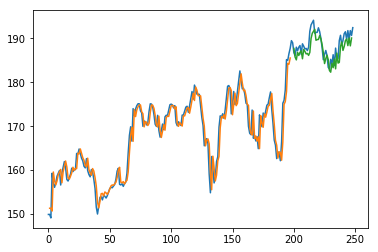

Last Day Value: 190.0924072265625
Next Day Value: 181.33010864257812


In [8]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(numpy.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", numpy.asscalar(last_val))
print ("Next Day Value:", numpy.asscalar(last_val*next_val))